# 2025 Pocono Monte Carlo Simulation

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

In [21]:
cup_roster = pd.read_csv("C:/Users/jakel/OneDrive/Desktop/GitHub/NASCAR-Race-Predictions/Master-Data/2025-cup-series-full-timers.txt")

In [22]:
simulation_data = pd.read_csv("C:/Users/jakel/OneDrive/Desktop/GitHub/NASCAR-Race-Predictions/Pocono-Driver-Data/pocono-sim-ready-data.csv")
simulation_data.head()

,Unnamed: 0,Driver,Avg Finish,Races,Wins,Top 5's,Top 10's,Laps Led,DNF,Avg Rating,DNF_Prob,Laps Led Per Race,Std Dev
0,0,William Byron,9.4,11,0,3,6,130,0,96.7,0.030000,11.818182,2.5
1,1,Brad Keselowski,10.8,27,1,11,16,247,1,94.4,0.037037,9.148148,2.5
2,2,Denny Hamlin,11.3,35,7,16,23,858,3,108.7,0.085714,24.514286,2.5
3,3,Kyle Larson,11.6,17,0,5,9,158,0,95.8,0.030000,9.294118,2.5
4,5,Ryan Blaney,13.4,15,2,3,7,95,1,89.6,0.066667,6.333333,3.5


In [23]:
def simulate_race(df):
    finish_positions = []
    
    for _, row in df.iterrows():
        # quick check for a DNF
        dnf = np.random.rand() < row['DNF_Prob']
        
        if dnf:
            # DNF finish at the back of the pack
            finish_pos = np.random.randint(len(df) + 1, len(df) + 6)
        else:
            # Finished race: sample finish from a normal distribution centered at Avg Finish
            # use the std dev calculated from avg finish to control variability
            finish_pos = np.random.normal(loc=row['Avg Finish'], scale=row['Std Dev'])
            
            # bound finish position between 1 and number of drivers so we get nothing crazy
            finish_pos = max(1, min(len(df), finish_pos))
        
        finish_positions.append((row['Driver'], finish_pos, dnf))
    
    # convert the list to a dataframe to sort and view easier
    results = pd.DataFrame(finish_positions, columns=['Driver', 'Finish_Pos', 'DNF'])
    
    # sort by DNF first (non-DNF comes first), then finish position
    results = results.sort_values(by=['DNF', 'Finish_Pos'], ascending=[True, True]).reset_index(drop=True)
    
    # driver in position 0 is the winner of that simulation
    winner = results.iloc[0]['Driver']
    return winner

def run_simulations(df, num_simulations=10000):
    win_counts = {driver: 0 for driver in df['Driver']}
    
    for i in range(num_simulations):
        winner = simulate_race(df)
        win_counts[winner] += 1
    
    # convert the list to a dataframe to sort and view easier
    win_probs = pd.DataFrame(list(win_counts.items()), columns=['Driver', 'Wins'])
    win_probs['Win_Prob'] = win_probs['Wins'] / num_simulations
    win_probs = win_probs.sort_values(by='Win_Prob', ascending=False).reset_index(drop=True)
    return win_probs


In [24]:
# run the simulation
results = run_simulations(simulation_data)
print(results)

                  Driver  Wins  Win_Prob
0          William Byron  3351    0.3351
1        Brad Keselowski  1489    0.1489
2           Denny Hamlin  1105    0.1105
3            Kyle Larson   904    0.0904
4            Ryan Blaney   617    0.0617
5          Tyler Reddick   608    0.0608
6          Chase Elliott   576    0.0576
7             Erik Jones   544    0.0544
8       Christopher Bell   103    0.0103
9             Kyle Busch    96    0.0096
10         Daniel Suarez    93    0.0093
11              Ty Gibbs    88    0.0088
12         Bubba Wallace    71    0.0071
13        Carson Hocevar    64    0.0064
14           Alex Bowman    61    0.0061
15         Austin Dillon    57    0.0057
16            Josh Berry    45    0.0045
17           Joey Logano    40    0.0040
18        Chris Buescher    35    0.0035
19         Chase Briscoe    23    0.0023
20   Ricky Stenhouse Jr.    10    0.0010
21     A.J. Allmendinger     7    0.0007
22             Ty Dillon     6    0.0006
23  John Hunter 

C:\Users\jakel\AppData\Local\Temp\ipykernel_21056\1306530603.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x='Win_Prob', y='Driver', palette='viridis')


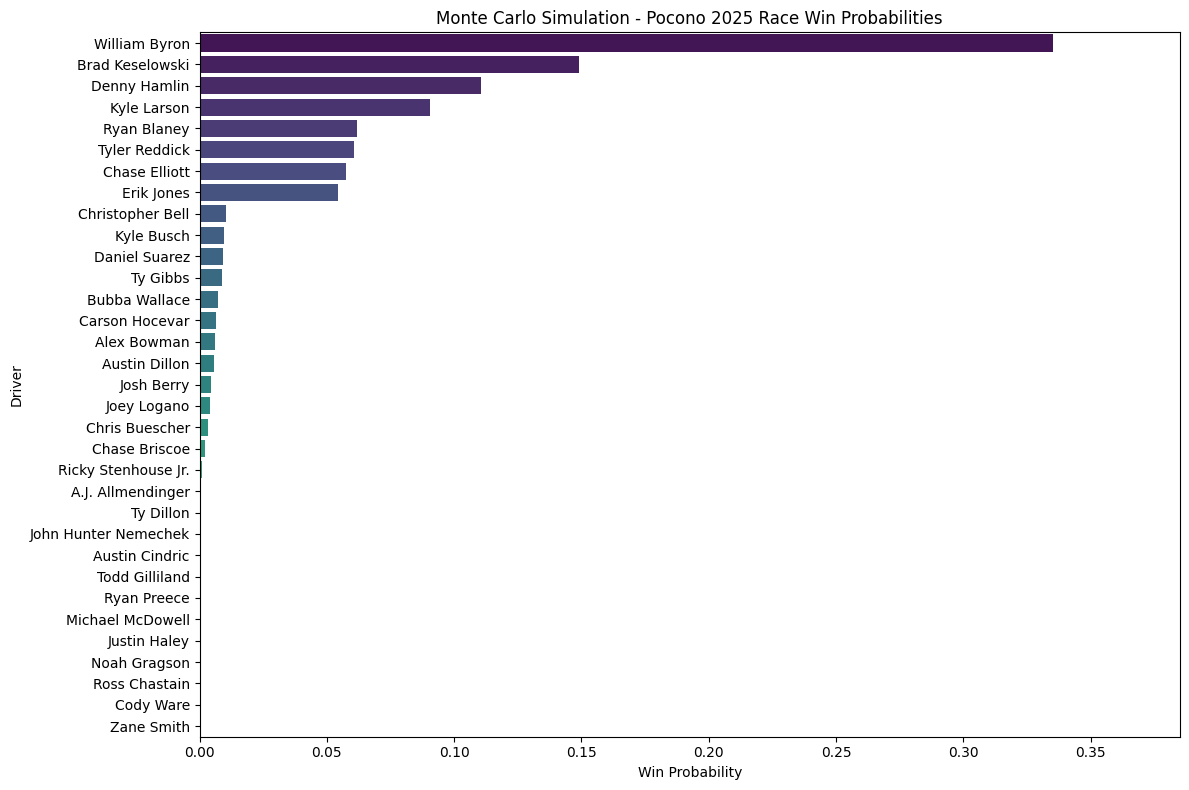

In [25]:
plt.figure(figsize=(12, 8))
sns.barplot(data=results, x='Win_Prob', y='Driver', palette='viridis')

plt.xlabel('Win Probability')
plt.ylabel('Driver')
plt.title('Monte Carlo Simulation - Pocono 2025 Race Win Probabilities')
plt.xlim(0, results['Win_Prob'].max() + 0.05)

plt.tight_layout()
plt.show()

In [26]:
results_with_nums = results.merge(cup_roster[['Driver', 'Car No.']], on='Driver', how='left')
top_10 = results_with_nums.sort_values(by='Win_Prob', ascending=False).head(10).reset_index(drop=True)
top_10

,Driver,Wins,Win_Prob,Car No.
0,William Byron,3351,0.3351,24
1,Brad Keselowski,1489,0.1489,6
2,Denny Hamlin,1105,0.1105,11
3,Kyle Larson,904,0.0904,5
4,Ryan Blaney,617,0.0617,12
5,Tyler Reddick,608,0.0608,45
6,Chase Elliott,576,0.0576,9
7,Erik Jones,544,0.0544,43
8,Christopher Bell,103,0.0103,20
9,Kyle Busch,96,0.0096,8


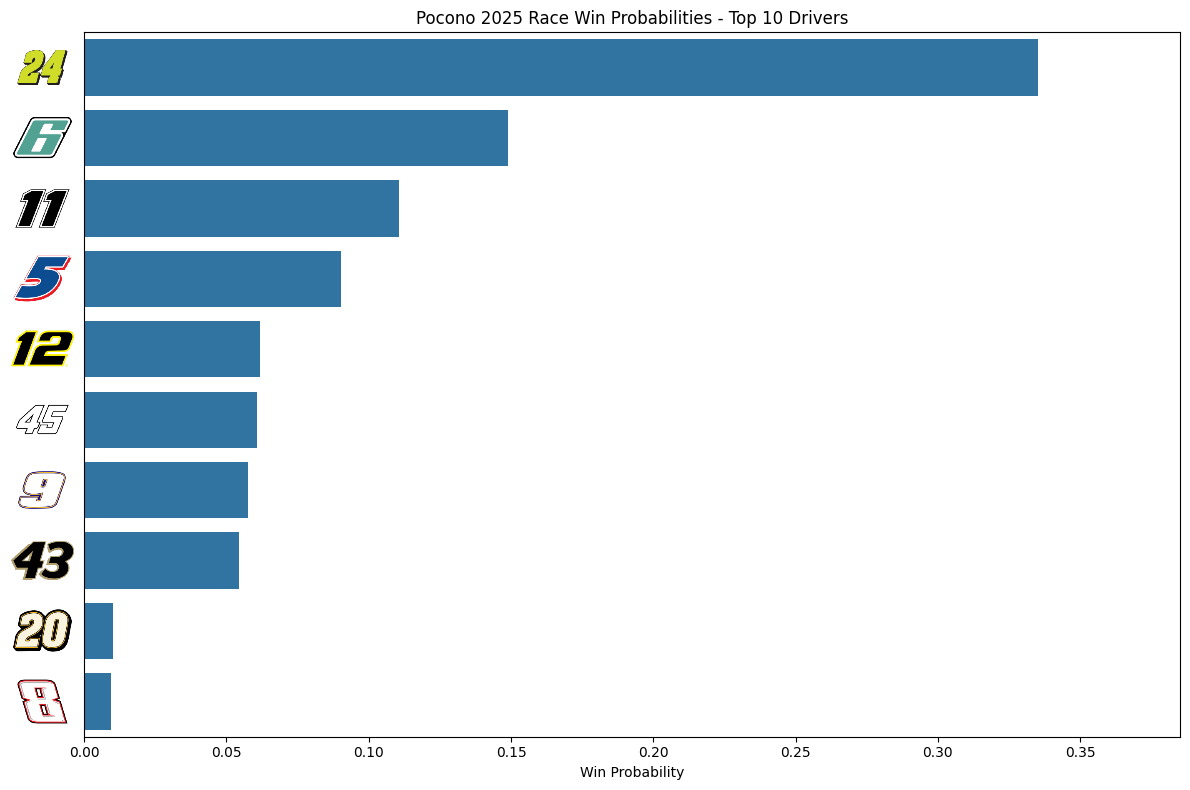

In [28]:
plt.figure(figsize=(12, 8))
barplot = sns.barplot(data=top_10, x='Win_Prob', y='Driver')

# Remove y-axis text labels
plt.yticks([])

plt.xlabel('Win Probability')
plt.ylabel('')
plt.title('Pocono 2025 Race Win Probabilities - Top 10 Drivers')
plt.xlim(0, top_10['Win_Prob'].max() + 0.05)

# Add car number images
for i, car_num in enumerate(top_10['Car No.']):
    img_path = f"C:/Users/jakel/OneDrive/Desktop/GitHub/NASCAR-Race-Predictions/Driver-Num-Logos/{car_num}.png"
    image = plt.imread(img_path)
    im = OffsetImage(image, zoom=0.3)
    ab = AnnotationBbox(im, (0, i), xybox=(-30, 0), frameon=False,
                        xycoords='data', boxcoords="offset points", pad=0)
    plt.gca().add_artist(ab)

plt.tight_layout()
plt.show()